In [6]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import sys

sys.path.append("../trimmingSession")
sys.path.append("~/.local/share/fonts")
from util import *
from stationUtil import *
from graph import *

In [7]:
import matplotlib.font_manager as fm

SHARE_PATH = "/usr/share/fonts"
font_name = fm.FontProperties(
    fname=f"{SHARE_PATH}/Pretendard/PretendardGOV-Medium.ttf"
).get_name()
plt.rc("font", family=font_name)

In [8]:
SENARIO = pd.read_json("../database/SENARIO.json")

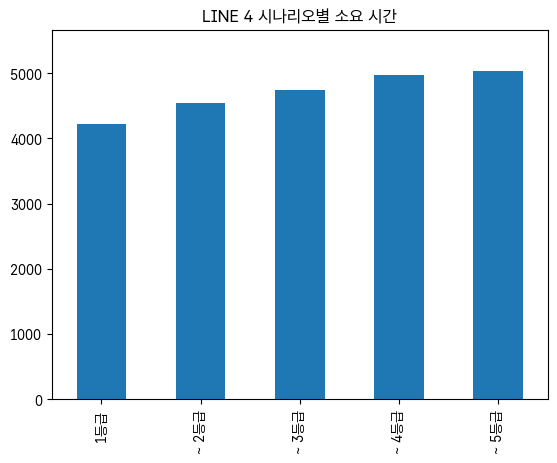

In [9]:
MAX_TIME = 5040 * 1.125
for line in [1, 2, 3, 4]:
    df_line = SENARIO[SENARIO["LINE"] == line].copy(deep=True)
    df_line.index = (
        df_line["GRADE"]
        .apply(lambda _X: "~ " + str(_X) + "등급" if not _X == 1 else "1등급")
        .to_numpy()
    )
    ax = df_line["TIME"].plot.bar()
    fig = ax.get_figure()

    ax.set_title(f"LINE {line} 시나리오별 소요 시간")
    ax.set_ylim(0, MAX_TIME)
    fig.savefig(f"line{line}_senario_diff.svg", format="svg")